In [1]:
import numpy as np
import PIL

### **SOW-MKI49-2020-SEM1-V: NeurIPS**
#### Project: Neurosmash

This is the info document on the Neurosmash environment that you will be using for your Final Assignment. It contains background info and skeleton code to get you started.

### Project

During the 2nd period, you will be working exclusively on this final group project in the practicals. You are expected to form groups of 4-5 people. The goal is to take what has been discussed in class and what you have already worked on in the earlier practicals, and apply them on a RL problem in a novel environment. This  project will constitute 25% of your final grade.

Your project grade will be based on the following components:
- Online demonstration
- Source code
- Written report (a 4-page report in NeurIPS workshop paper format: https://www.overleaf.com/latex/templates/neurips-2020/mnshsmqkjsqz)

These components will be evaluated based on performance, creativity, elegance, rigor and plausibility.

While you can use the material from earlier practicals (e.g., REINFORCE, DQN, etc.) as a boilerplate, you are also free to take any other approach be it imitation learning or world models for your project.

As a deep learning library, use of mxnet is preferred. Still, you are free to use whatever you want.

In addition to the practical sessions, we will provide additional support in the coming weeks. You can email any of us to set up an appointment for discussing your project.

### Environment

Briefly, there are two agents: Red and Blue. Red is controlled by you. Blue is controlled by the environment "AI".* Both agents always run forward with a speed of 3.5 m/s*. If one of them gets within the reach of the other (a frontal sphere with 0.5 m radius), it gets pushed away automatically with a speed of 3.5 m/s. The only thing that the agents can do is to turn left or right with an angular speed of 180 degrees/s. This means that there are three possible discrete actions that your agent can take every step: Turn nowhere, turn left and turn right. For convenience, there is also a fourth built-in action which turns left or right with uniform probability. An episode begins when you reset the environment and ends when one of the agents fall off the platform. At the end of the episode, the winning agent gets a reward of 10 while the other gets nothing. Therefore, your goal is to train an agent who can maximize its reward by pushing the other agent off the platform or making it fall off the platform by itself.

* Note that all times are simulation time. That is, 0.02 s per step when timescale is set to one.

* Basically, Blue is artificial but not really intelligent. What it does is that every 0.5 s, it updates its destination to the current position of Red plus some random variation (a surrounding circle with a radius of 1.75 m) and smoothly turns to that position.

Note to macOS users: You should first make the environment executable* in the terminal and run it from the context menu (i.e., not by double clicking)

* chmod -R +x [Path of Mac.app (which is in the .zip file)]/Contents/MacOS

### Skeleton code

- You should first add the Neurosmash file to your working directory or Python path.
- Next you should start the Neurosmash app 
- Make sure to set the right values in the Ip, Port, Size and Timescale fields (see below). These must correspond to the values you specify in the python script
- Start the server by pressing the play button
- The fastest simulations can be obtained by turning off rendering (x button)

In [2]:
import Neurosmash

# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to (127.0.0.1 by default)
port       = 13000       # Port number that the TCP/IP interface listens to (13000 by default)

# This is the size of the texture that the environment is rendered.
# This is set to 784 by default, which will result in a crisp image but slow speed.
# You can change the size to a value that works well for your environment but should not go too low.
size       = 96

# This is the simulation speed of the environment. This is set to 1 by default.
# Setting it to n will make the simulation n times faster.
# In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step.
# You might want to increase this value to around 10 if you cannot train your models fast enough
# so that they can sample more states in a shorter number of steps at the expense of precision.
timescale  = 5

# This is an example agent.
# It has a step function, which gets reward/state as arguments and returns an action.
# Right now, it always outputs a random action (3) regardless of reward/state.
# The real agent should output one of the following three actions:
# none (0), left (1) and right (2)
agent = Neurosmash.Agent() 

# This is the main environment.
# It has a reset function, which is used to reset the environment before episodes.
# It also has a step function, which is used to which steps one time point
# It gets an action (as defined above) as input and outputs the following:
# end (true if the episode has ended, false otherwise)
# reward (10 if won, 0 otherwise)
# state (flattened size x size x 3 vector of pixel values)
# The state can be converted into an image as follows:
# image = np.array(state, "uint8").reshape(size, size, 3)
# You can also use to Neurosmash.Environment.state2image(state) function which returns
# the state as a PIL image
environment = Neurosmash.Environment(ip, port, size, timescale) 



In [7]:
# !pip install mxnet==1.6
!pip install gluonts

In [8]:
import mxnet
#import gluonts

ModuleNotFoundError: No module named 'gluonts'

In [9]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import autograd, gluon, nd, init 
from mxnet.gluon import nn, Block
from mxnet.gluon.nn import LeakyReLU

from gluonts.distribution.distribution.Distribution import Gaussian
from gluonts.distribution.mixture import MixtureModule


import tqdm


class MDN_RNN():
    
    def __init__(z_dim, h_dim1, h_dim2, components):
        """
        Initialization Mixture Density Network - RNN model.
        
        :param z_dim (int) Input dimensions, latent vector of VAE  
        :param h_dim1 (int) First hidden layer dimension
        :param h_dim2 (int) Second hidden layer dimension
        :param components (int)

        return: MDN RNN object
        """
        # Initialize parameters
        self.z_dim = z_dim
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.components = components
        
        # Create hidden layer 
        self.h1 = nn.Dense(h_dim1, activation='relu')
        self.h2 = nn.Dense(h_dim2, activation='relu')

        
        # Create output layer for Mixture Density Network
        self.means = nn.Dense(components)
        self.sigmas = nn.Dense(components)
        self.weights = nn.Dense(components)
        
    def forward(x):
        """
        Forward pass of the model for 1 time step
        
        :param x (Numpy array) Concatinated array of h-1, z-1 and a-1

        return: means
        """
        # 
        x = self.h1(x)
        x = self.h2(x)
        
        means = self.means(x)
        sigmas = self.sigmas(x)
        weights = self.weights(x)
        
        return means, sigmas, weights
        
#     def backward():
#         """"
#         Update gradient of weights using mxnet
        
#         return: gradient of error
#         """"
        
        
z_dim, h_dim, components = 32, 16, 2
rnn = MDN_RNN(z_dim, h_dim, components)


# Input: z-1, h-1, a-1
# target: z
# Output: approximation for z

ModuleNotFoundError: No module named 'gluonts'

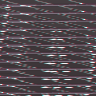

In [5]:
# The following steps through an entire episode from start to finish with random actions (by default)

end, reward, state = environment.reset()

while (end == 0):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

# Let's run it a few more steps so that the things have time to settle down

for i in range(1000):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

environment.state2image(state)

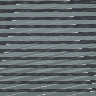

In [13]:
# Let's also do it step by step while displaying the state

end, reward, state = environment.reset()

environment.state2image(state)

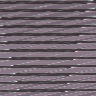

In [14]:
action = agent.step(end, reward, state)
end, reward, state = environment.step(action)

environment.state2image(state)

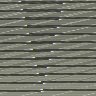

In [15]:
action = agent.step(end, reward, state)
end, reward, state = environment.step(action)

environment.state2image(state)

In [ ]:
# etc.